# Random Forest

In [1]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from src.preprocessing import *
from src.visualization import *
from src.trainer import *
from src.helpers import *
from src.config import *

In [2]:
model_name       = 'rf'
best_params_path = paths[model_name]['best_params']
model_path_list  = paths[model_name]['models']
pred_5folds_path = paths[model_name]['pred_5folds']
shap_fi_path     = paths[model_name]['shap_fi']
fi_path          = paths[model_name]['feature_importance']

## 1. Load data

In [3]:
# Get lists of data by folds
X_train_list = [pd.read_csv(path) for path in X_train_paths]
y_train_list = [pd.read_csv(path) for path in y_train_paths]
y_train_list = [y_train[TARGET].to_numpy() for y_train in y_train_list]

X_val_list   = [pd.read_csv(path) for path in X_val_paths]
y_val_list   = [pd.read_csv(path) for path in y_val_paths]
y_val_list   = [y_val[TARGET].to_numpy() for y_val in y_val_list]

## 2. Hyperparameters Tuning

In [4]:
def objective(trial):    
    param = {
        'n_estimators'     : trial.suggest_int('n_estimators', 10, 200),
        'max_depth'        : trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 20),
        'class_weight'     : trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),
        'max_features'     : trial.suggest_int('max_features', 1, 5),
        'criterion'        : 'log_loss',
        'n_jobs'           : -1,
        'oob_score'        : True,
        'random_state'     : RANDOM_STATE,
    }
    
    trainer = BaseTrainer(model=RandomForestClassifier(**param))
    mean_metrics, *_ = trainer.perform_cross_validation(
        X_train_list, y_train_list,
        X_val_list, y_val_list,
        verbose=0
    )
    avg = (mean_metrics.get('mean_accuracy') + mean_metrics.get('mean_f1_score') + mean_metrics.get('mean_roc_auc')) / 3
    return avg

In [5]:
HP_TUNING=False

if HP_TUNING:
    direction = 'maximize'
    n_trials  = 500
    n_jobs    = -1

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials, n_jobs=n_jobs)

    best_params = study.best_trial.params
    best_params.update({
        'criterion'   : 'log_loss',
        'n_jobs'      : -1,
        'oob_score'   : True,
        'random_state': RANDOM_STATE,
    })
else:
    best_params = load_json(best_params_path)
    
best_params

{'n_estimators': 196,
 'max_depth': 17,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'class_weight': 'balanced_subsample',
 'max_features': 3,
 'criterion': 'log_loss',
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 42}

## 3. Train with 5-fold cross validation

In [6]:
trainer = BaseTrainer(model=RandomForestClassifier(**best_params))
mean_metrics, y_pred_list, y_pred_proba_list, fi_list = trainer.perform_cross_validation(
    X_train_list=X_train_list,
    y_train_list=y_train_list,
    X_val_list=X_val_list,
    y_val_list=y_val_list,
    #model_path_list=model_path_list, # uncomment if you want to save newly trained models
    verbose=1,
)

Fold 1/5:
	- ACCURACY: 0.8000
	- ROC_AUC: 0.8840
	- F1_SCORE: 0.7755
	- MSE: 0.1450
	- PRECISION: 0.7917
	- RECALL: 0.7600
	- SPECIFICITY: 0.8333

Fold 2/5:
	- ACCURACY: 0.8909
	- ROC_AUC: 0.9480
	- F1_SCORE: 0.8889
	- MSE: 0.1113
	- PRECISION: 0.8276
	- RECALL: 0.9600
	- SPECIFICITY: 0.8333

Fold 3/5:
	- ACCURACY: 0.8364
	- ROC_AUC: 0.9200
	- F1_SCORE: 0.8235
	- MSE: 0.1317
	- PRECISION: 0.8077
	- RECALL: 0.8400
	- SPECIFICITY: 0.8333

Fold 4/5:
	- ACCURACY: 0.8519
	- ROC_AUC: 0.8979
	- F1_SCORE: 0.8519
	- MSE: 0.1466
	- PRECISION: 0.7931
	- RECALL: 0.9200
	- SPECIFICITY: 0.7931

Fold 5/5:
	- ACCURACY: 0.8148
	- ROC_AUC: 0.9186
	- F1_SCORE: 0.8000
	- MSE: 0.1320
	- PRECISION: 0.8000
	- RECALL: 0.8000
	- SPECIFICITY: 0.8276

------------------------------
	- MEAN_ACCURACY: 0.8388
	- MEAN_ROC_AUC: 0.9137
	- MEAN_F1_SCORE: 0.8280
	- MEAN_MSE: 0.1333
	- MEAN_PRECISION: 0.8040
	- MEAN_RECALL: 0.8560
	- MEAN_SPECIFICITY: 0.8241


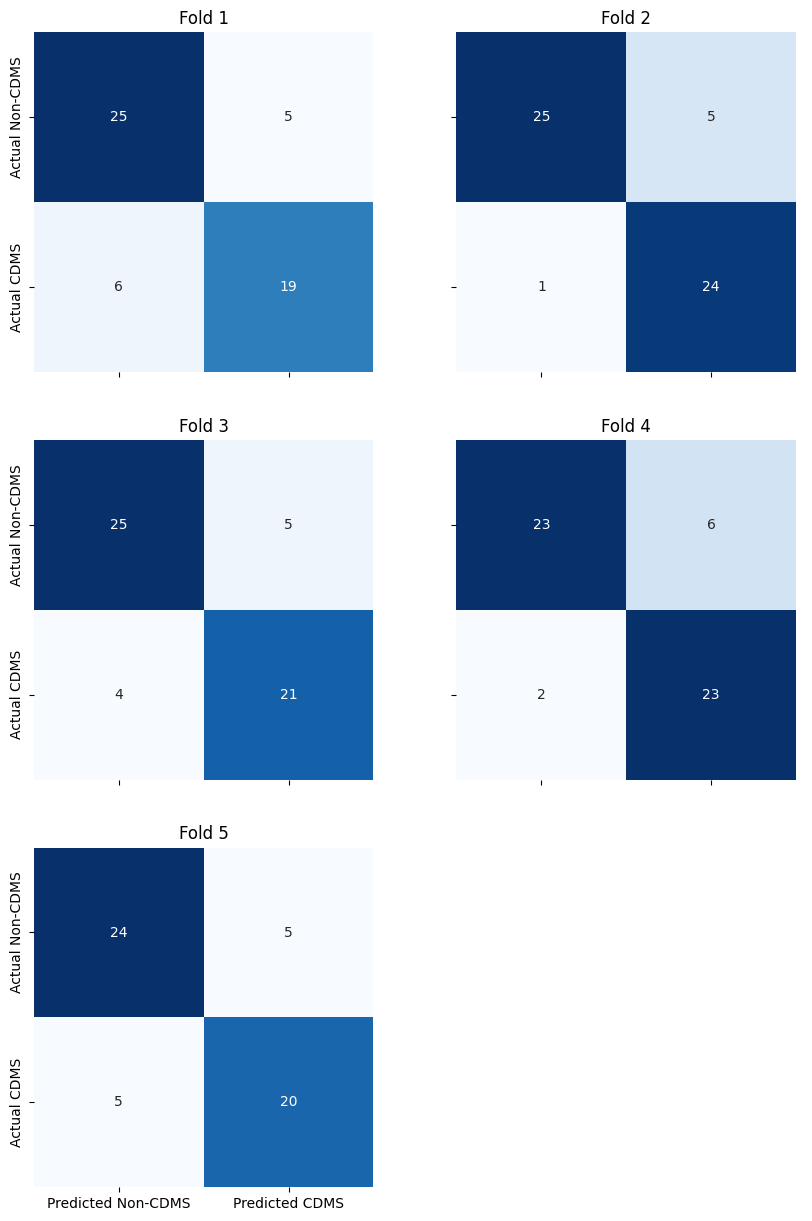

In [7]:
plot_confusion_matrix_folds(
    y_test_list=y_val_list,
    y_pred_list=y_pred_list,
)

## 5. Feature Importance

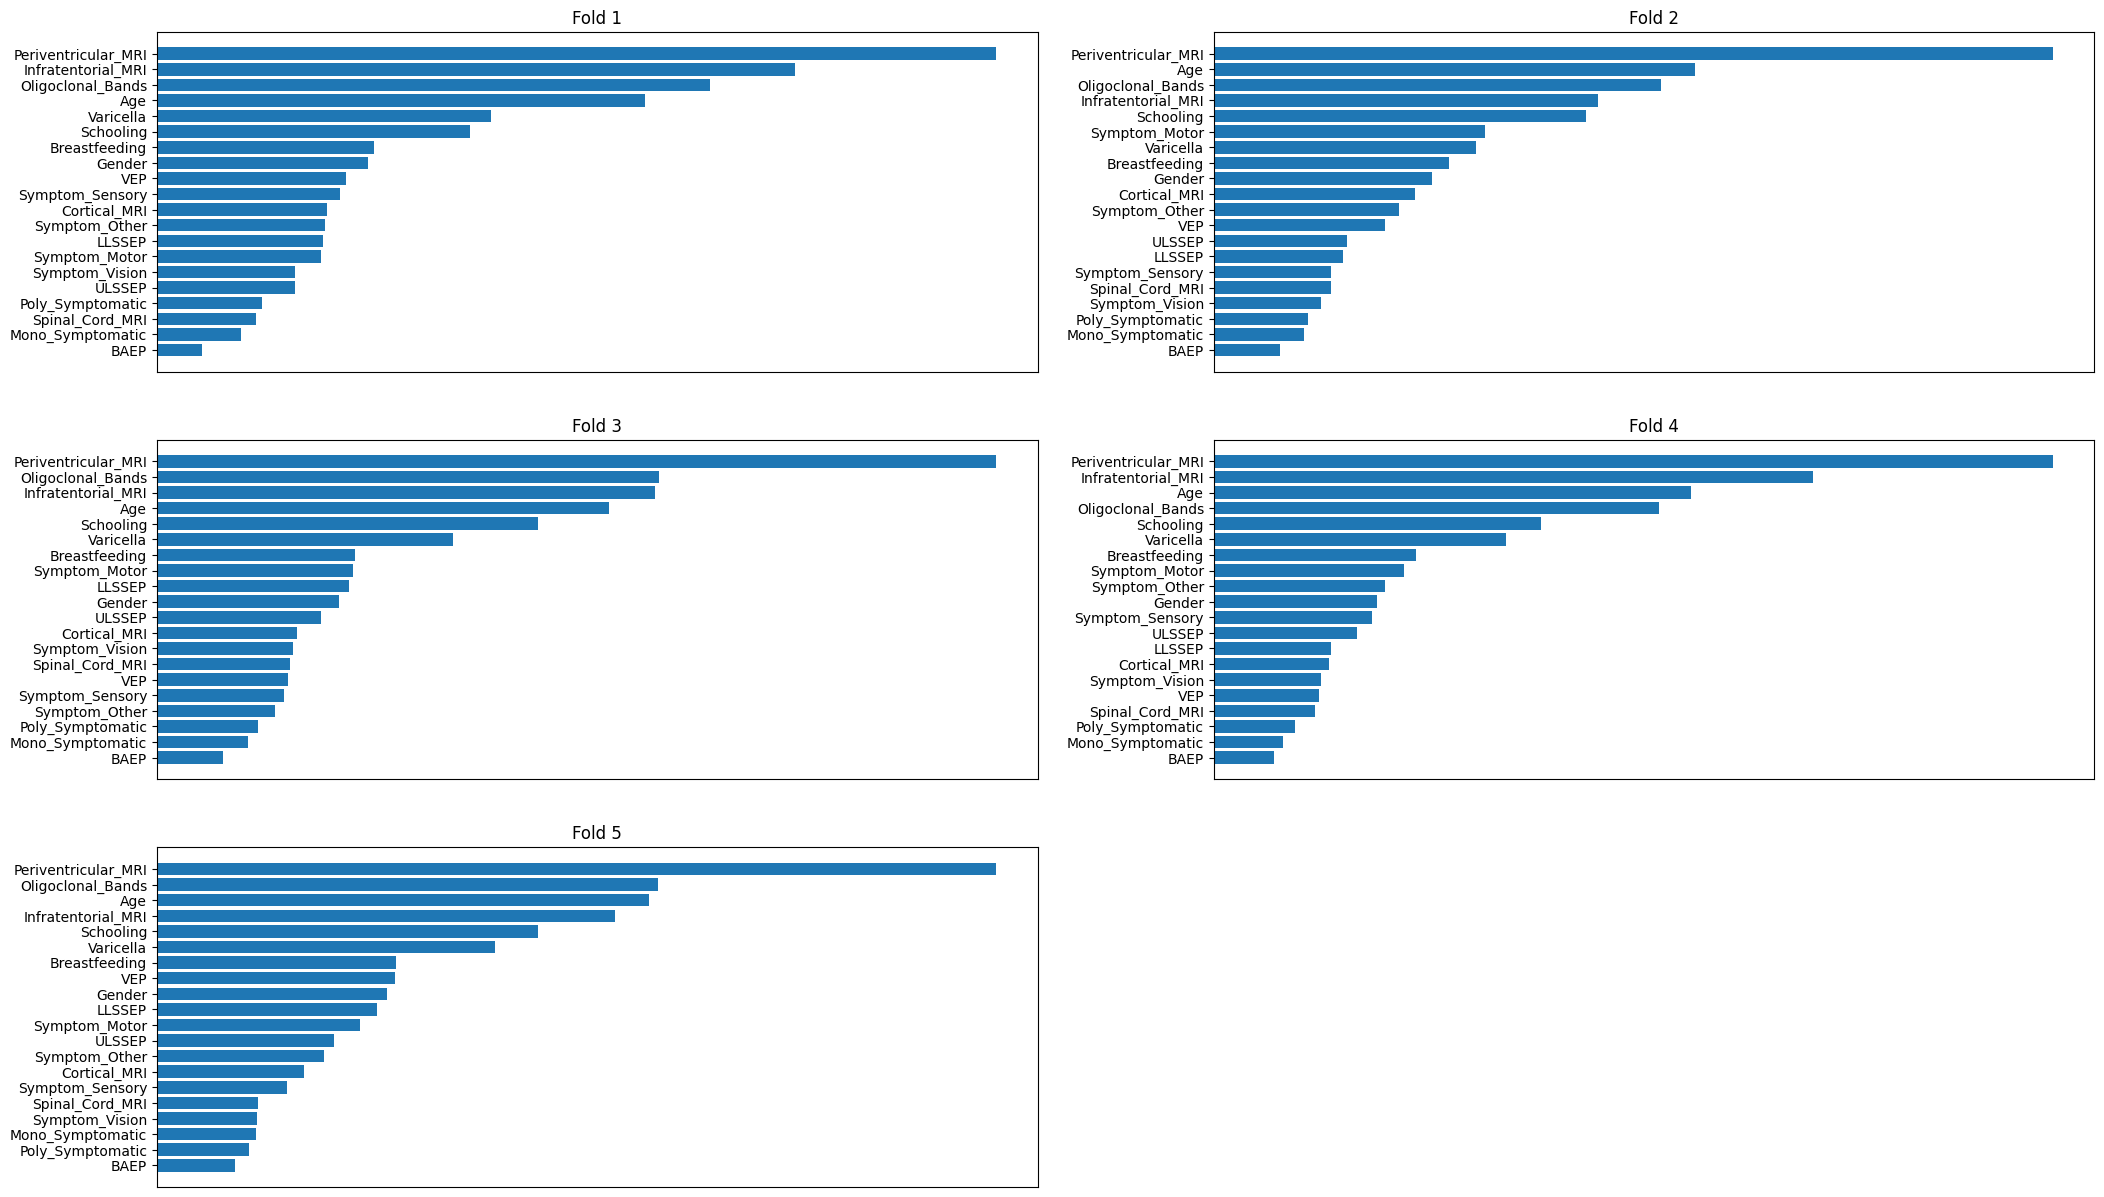

In [8]:
plot_catboost_feature_importance_folds(
    fi_list=fi_list,
    columns_folds=[X_train.columns for X_train in X_train_list]
)

In [9]:
fi_dfs = []
for fi, X_train_fold in zip(fi_list, X_train_list):
    fi_df = pd.DataFrame({'Feature Id': X_train_fold.columns, 'Importances': fi})
    fi_dfs.append(fi_df)


feature_importance = average_feature_importances(fi_dfs)
# feature_importance.to_csv(fi_path, index=False)
feature_importance

,Feature Id,Importances
0,Periventricular_MRI,0.167268
1,Infratentorial_MRI,0.102741
2,Oligoclonal_Bands,0.097438
3,Age,0.095292
4,Schooling,0.070809
5,Varicella,0.060579
6,Breastfeeding,0.043520
7,Symptom_Motor,0.040930
8,Gender,0.039923
9,VEP,0.032955


## 5. Get predictions

In [10]:
analyzed_dfs = []

for fold in range(1, 6):
    # Load data for the current fold
    X_train, y_train, X_val, y_val = load_data_fold(fold)

    # Load trained model for the current fold
    model = load_model_fold(fold, model_name=model_name)

    # Get predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:,-1]

    # Add ground truths and predictions to the current df
    analyzed_df = X_val.copy()
    analyzed_df['Actual'] = y_val
    analyzed_df['Predicted'] = y_pred
    analyzed_df['Predicted_Proba'] = y_pred_proba
    analyzed_dfs.append(analyzed_df)

analyzed_df_aggregated = pd.concat(analyzed_dfs, axis=0).reset_index(drop=True)
print(f'analyzed_df_aggregated.shape: {analyzed_df_aggregated.shape}')

# analyzed_df_aggregated.to_csv(pred_5folds_path, index=False)
# print(f'Save df to {pred_5folds_path}')

analyzed_df_aggregated.shape: (273, 23)


## 6. Explain with SHAP

In [11]:
import shap

models = [load_model_fold(fold+1, model_name) for fold in range(5)]
shap_values_folds = []

for fold in range(5):
    model = models[fold]
    X_val = X_val_list[fold]

    explainer = shap.TreeExplainer(model)
    sv = explainer.shap_values(X_val)
    mean_sv = np.mean(np.abs(sv), axis=0)
    shap_values_folds.append(mean_sv)

# Aggregate SHAP values across folds
aggregated_shap_values = np.mean(shap_values_folds, axis=0)

# Calculate mean absolute SHAP values for feature importance
feature_names = X_val_list[0].columns.to_list()
shap_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.mean(aggregated_shap_values, axis=1)
})

# Sort by importance
shap_feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
#shap_feature_importance.to_csv(shap_fi_path, index=False)
shap_feature_importance

,Feature,Importance
10,Periventricular_MRI,0.118054
12,Infratentorial_MRI,0.076094
5,Oligoclonal_Bands,0.070531
2,Schooling,0.035257
16,Symptom_Motor,0.034496
17,Symptom_Other,0.026560
0,Gender,0.025940
4,Varicella,0.025894
6,LLSSEP,0.024762
11,Cortical_MRI,0.023051
